In [1]:
%matplotlib inline

# Машинное обучение
## ВМК МГУ, весна 2015/2016
## Лабораторная работа 1. Линейные модели

ФИО: Копин Борис Александрович

Группа:

Данное задание посвящено применению линейных моделей в задачах классификации и регрессии. Вы научитесь:
* делать one-hot-кодирование категориальных признаков
* обучать логистическую и линейную регрессию
* отбирать признаки с помощью LASSO
* вычислять метрики качества классификации и регрессии
* выбирать лучший классификатор при ограничениях на точность или полноту
* калибровать вероятности
* реализовывать градиентный спуск (если захотите)


In [2]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
plt.style.use('ggplot')

## Часть 1. Научные гранты в Австралии

![](http://imgur.com/cBdDBO3.jpg)

В данной части мы будем работать с задачей "Predict Grant Applications" (https://www.kaggle.com/c/unimelb/data), где для заявки на грант требуется предсказать, одобрят её или нет. Будем использовать лишь 40 признаков из имеющихся 249. Файлы для работы можно найти по ссылкам:
* https://db.tt/iYzRzQYP (обучение)
* https://db.tt/NGSHb5Qs (контроль)

#### Задание 1
Считайте обучающую и контрольную выборки из файлов с помощью pd.read_csv. Выделите целевую переменную (Grant.Status) в отдельный вектор.

In [3]:
unimel_train = pd.read_csv("./unimel_train.csv")
y_train = unimel_train["Grant.Status"].as_matrix().ravel()
data_train = unimel_train.drop(["Grant.Status"], axis=1)


In [4]:
unimel_test = pd.read_csv("./unimel_test.csv")
y_test = unimel_test["Grant.Status"].as_matrix().ravel()
data_test = unimel_test.drop(["Grant.Status"], axis=1)

#### Задание 2
В этом задании мы приведем данные к виду, пригодному для обучения линейных классификаторов. Для этого вещественные признаки надо отмасштабировать, а категориальные — привести к числовому виду. Также надо устранить пропуски в данных.

В первую очередь поймем, зачем здесь нужно масштабирование. Нарисуем распределение трех признаков.

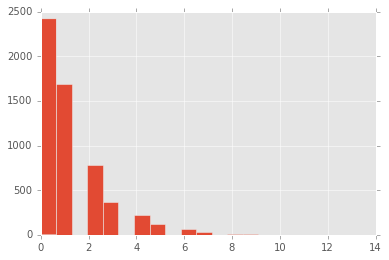

In [5]:
data_train['Number.of.Successful.Grant.1'].hist(bins=20)

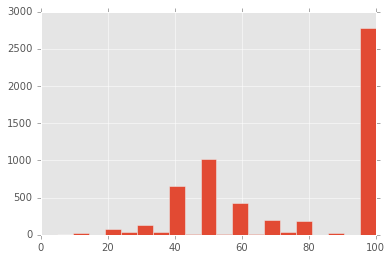

In [6]:
data_train['RFCD.Percentage.1'].hist(bins=20)

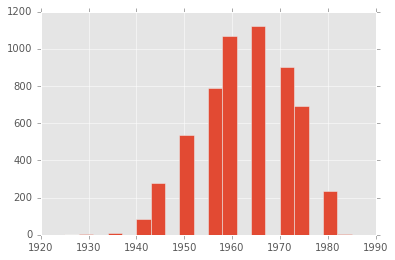

In [7]:
data_train['Year.of.Birth.1'].hist(bins=20)

Какую проблему вы наблюдаете на этих графиках? Как масштабирование поможет её исправить?

**Шкалы признаков различны, масштабирование сведет все признаки к одной шкале.**

В наших данных есть пропуски. Ответьте на вопросы:
1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
2. Сколько объектов имеют хотя бы один пропуск?
3. Сколько признаков имеют хотя бы одно пропущенное значение?

In [8]:
print "1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?"
print "   - ", np.sum(np.sum(data_train.isnull()))

print "2. Сколько объектов имеют хотя бы один пропуск?"
print "   - ", np.sum(np.sum(data_train.isnull(), axis=1) >= 1)," из ", len(data_train)

print "2. Сколько признаков имеют хотя бы одно пропущенное значение?"
print "   - ", np.sum(np.sum(data_train.isnull(), axis=0) >= 1)," из ", len(data_train.columns)

1. Сколько всего пропущенных элементов в таблице с обучающей выборкой?
   -  26843
2. Сколько объектов имеют хотя бы один пропуск?
   -  5879  из  6095
2. Сколько признаков имеют хотя бы одно пропущенное значение?
   -  38  из  39


Большинство признаков в нашем датасете являются категориальными. Типичным подходом к работе с ними является бинарное, или one-hot-кодирование (также есть подход со счётчиками, который мы уже применяли в прошлых работах). Для начала потренируемся делать бинарное кодирование на трех игрушечных объектах.

In [9]:
simple_data = pd.DataFrame({'City': ['Msk', 'SPb', 'Msk'], 'Weather': [4.0, 3.0, 2.0]})
simple_data.head()

,City,Weather
0,Msk,4
1,SPb,3
2,Msk,2


In [10]:
# преобразуем каждый объект в dict
simple_data_dict = simple_data.T.to_dict().values()
print simple_data_dict

[{'City': 'Msk', 'Weather': 4.0}, {'City': 'SPb', 'Weather': 3.0}, {'City': 'Msk', 'Weather': 2.0}]


In [11]:
# делаем one-hot-кодирование
from sklearn.feature_extraction import DictVectorizer
transformer = DictVectorizer(sparse=False)
# примените здесь DictVectorizer к simple_data_dict, получите бинарную матрицу и выведите её
transformer.fit_transform(simple_data_dict)

array([[ 1.,  0.,  4.],
       [ 0.,  1.,  3.],
       [ 1.,  0.,  2.]])

Реализуйте функцию transform_data, которая принимает на вход DataFrame с признаками, объекты классов StandardScaler и DictVectorizer и булеву переменную is_test (True, если обрабатывает тестовую выборку и False, если обучающую). В функции должны выполняться следующие шаги:
1. Замена пропущенных значений на нули для вещественных признаков и на строки 'nan' для категориальных. Используйте для выполнения замены функцию fillna. Имена всех вещественных переменных перечислены в numeric_cols.
2. Масштабирование вещественных признаков с помощью StandardScaler (метод fit_transform, если is_test == False, и метод transform в противном случае).
3. One-hot-кодирование категориальных признаков с помощью DictVectorizer (метод fit_transform, если is_test == False, и метод transform в противном случае).

Метод должен возвращать tuple из трех элементов: преобразованной выборки, объекта StandardScaler и объекта DictVectorizer. Преобразованная выборка должна состоять из масштабированных вещественных признаков и закодированных категориальных (исходные признаки не должны в ней остаться).

In [12]:
def transform_data(data, scaler, transformer, is_test):
    cols = data.columns
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorical_cols = list(set(cols) - set(numeric_cols))

    numeric_data = data[numeric_cols].fillna(0)
    categorical_data = data[categorical_cols].fillna('nan').astype(str)
    
    if is_test:
        numeric_data = scaler.transform(numeric_data)
        categorical_data = transformer.transform(categorical_data.T.to_dict().values())
    else:
        numeric_data = scaler.fit_transform(numeric_data)
        categorical_data = transformer.fit_transform(categorical_data.T.to_dict().values())

    return np.hstack((numeric_data,categorical_data)), scaler, transformer

Применяем функцию к данным:

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformer = DictVectorizer(sparse=False)
X, scaler, transformer = transform_data(data_train, scaler, transformer, False)
X_test, _, _ = transform_data(data_test, scaler, transformer, True)

Сколько признаков у вас получилось после преобразования?

In [14]:
print X_test.shape[1]

11734


#### Задание 3
Подберите лучшее значение параметра регуляризации C для логистической регрессии с L2-регуляризатором (sklearn.linear_model.LogisticRegression) с помощью кросс-валидации по 5 блокам. В качестве метрики качества используйте AUC-ROC. Сетка для перебора указана ниже. По итогам кросс-валидации укажите лучшее значение параметра регуляризации. Обучите классификатор с этим параметром на всей обучающей выборке и найдите качество (AUC-ROC) на тестовой выборке.

In [15]:
from sklearn.cross_validation import KFold
cv = KFold(X.shape[0], n_folds=5, shuffle=True, random_state=241)

In [16]:
# вам пригодятся функции cross_val_score или GridSearchCV; используйте в них объект cv в качестве генератора разбиений
C_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import roc_auc_score

In [18]:
def search_params(estimator, params, x_train, y_train, scoring="roc_auc", cv=5):
    gsc = GridSearchCV(estimator, params, cv=cv, scoring=scoring)
    gsc.fit(x_train, y_train)
    print("Best parameters set found on development set:")
    print()
    print(gsc.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in gsc.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print()
    return gsc.best_estimator_, gsc.best_params_ 

In [19]:
gscl2, paramsl2 = search_params(LogisticRegression(penalty='l2'), {'C': C_grid}, X, y_train, cv=cv)

Best parameters set found on development set:
()
{'C': 0.1}
()
Grid scores on development set:
()
0.843 (+/-0.030) for {'C': 0.001}
0.873 (+/-0.021) for {'C': 0.01}
0.882 (+/-0.017) for {'C': 0.1}
0.877 (+/-0.012) for {'C': 1.0}
0.866 (+/-0.010) for {'C': 10.0}
0.861 (+/-0.010) for {'C': 100.0}
()


In [20]:
print "Качество c l2:"
print "    - ", roc_auc_score(y_test, gscl2.predict_proba(X_test)[:, 1])

Качество c l2:
    -  0.880340804287


Попробуем теперь логистическую регрессию с L1-регуляризатором (penalty='l1'). Выведите число ненулевых коэффициентов (clf.coef\_) при каждом значении параметра регуляризации из сетки.

In [21]:
gscl1, paramsl1 = search_params(LogisticRegression(penalty='l1'), {'C': C_grid}, X, y_train, cv=cv)

Best parameters set found on development set:
()
{'C': 1.0}
()
Grid scores on development set:
()
0.500 (+/-0.000) for {'C': 0.001}
0.860 (+/-0.018) for {'C': 0.01}
0.877 (+/-0.022) for {'C': 0.1}
0.880 (+/-0.013) for {'C': 1.0}
0.866 (+/-0.016) for {'C': 10.0}
0.864 (+/-0.015) for {'C': 100.0}
()


In [22]:
print "Качество c l1:"
print "    - ", roc_auc_score(y_test, gscl1.predict_proba(X_test)[:, 1])

Качество c l1:
    -  0.882258469689


In [23]:
for C in C_grid:
    estm = LogisticRegression(penalty='l1', C=C)
    estm.fit(X, y_train)
    nonezoro_coef = np.nonzero(estm.coef_)
    score = roc_auc_score(y_test, estm.decision_function(X_test))
    print "число ненулевых коэффициентов при С=",C, " -", len(estm.coef_[nonezoro_coef]), " auc=", score

число ненулевых коэффициентов при С= 0.001  - 0  auc= 0.5
число ненулевых коэффициентов при С= 0.01  - 9  auc= 0.852545565192
число ненулевых коэффициентов при С= 0.1  - 58  auc= 0.874043820895
число ненулевых коэффициентов при С= 1.0  - 668  auc= 0.882230164664
число ненулевых коэффициентов при С= 10.0  - 2420  auc= 0.872517413487
число ненулевых коэффициентов при С= 100.0  - 2858  auc= 0.871490766665


Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01? Сколько для достижения такого качества ей нужно признаков?

In [24]:
lr_l1 = LogisticRegression(penalty='l1', C=0.01)
lr_l1.fit(X, y_train)
print ("Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01?")
score_0_01 = roc_auc_score(y_test, lr_l1.decision_function(X_test))
print "   - ", score_0_01

Какое качество на тесте даёт логистическая регрессия с L1-регуляризатором с параметром C=0.01?
   -  0.85254615488


In [25]:
nonezoro_coef = np.nonzero(lr_l1.coef_)
print "число ненулевых коэффициентов - ", len(lr_l1.coef_[nonezoro_coef])

число ненулевых коэффициентов -  8


In [26]:
# Жадно выкидываем оставшиеся признаки, пока score не упадет меньше заданного
def feature_selection(estimator, x_train, y_train, x_test, y_test, fset, score_threshold):    
    fset = nonezoro_coef[1]

    for _ in range(len(nonezoro_coef[1])-1):
        scores = []
        for i in range(len(fset)):
            curr_fset = list(set(fset) - set([fset[i]]))
            
            estimator.fit(x_train[:, curr_fset], y_train)
            y_pred = estimator.decision_function(x_test[:, curr_fset])
            scores.append(roc_auc_score(y_test, y_pred))

        fset = list(set(fset) - set([fset[np.argmax(scores)]]))
        if np.max(scores) < score_threshold:
            print "Сколько для достижения такого качества ей нужно признаков?" 
            print "   - ", len(fset) +1
            break
        print np.max(scores), len(fset)
        
feature_selection(lr_l1, X, y_train, X_test, y_test, nonezoro_coef[1], score_0_01)

0.853333683215 7
0.8533885242 6
Сколько для достижения такого качества ей нужно признаков?
   -  6


#### Задание 4
В этом задании мы внимательно рассмотрим различные аспекты качества классификатора. Для этого возьмите классификатор с L2-регуляризатором с лучшим значением параметра регуляризации (вы его нашли в предыдущем задании), обучите на полной обучающей выборке и найдите предсказания вероятностей на тесте. Далее будем работать только с этими прогнозами.

In [27]:
lr_l2 = LogisticRegression(penalty='l2', **paramsl2)
lr_l2.fit(X,y_train)
y_pred = lr_l2.predict_proba(X_test)[:,1]

Посчитайте AUC-ROC, AUC-PR (average_precision_score) и log-loss для прогнозов.

In [28]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import log_loss

In [29]:
fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred)
auc(fpr, tpr)

0.8803408042872678

In [30]:
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_pred)
average_precision_score(y_test, y_pred)

0.83874939873234611

In [31]:
log_loss(y_test, y_pred)

0.4427420368281853

Нарисуйте ROC- и PR-кривые. Не забудьте подписать оси.

In [32]:
def plot_precision_recall_curve(recall, precision):
    plt.plot(recall, precision, label='Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

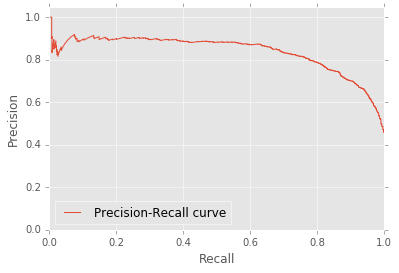

In [33]:
plot_precision_recall_curve(recall, precision)

In [34]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

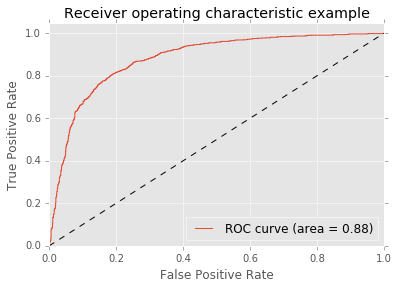

In [35]:
plot_roc_curve(fpr, tpr)

In [36]:
np.sum(recall[::-1])/np.sum(tpr)

1.0

Допустим, мы хотим построить классификатор, который будет находить не менее 90% успешных грантов. Соответственно, имеем нижнюю границу 90% на полноту. Какую максимальную точность при этом можно получить? При каком значении порога? Для получения ответа проанализируйте массивы, возвращаемые функцией metrics.precision_recall_curve.

Какую максимальную точность при этом можно получить?
0.701948051948
При каком пороге?
0.314906892564


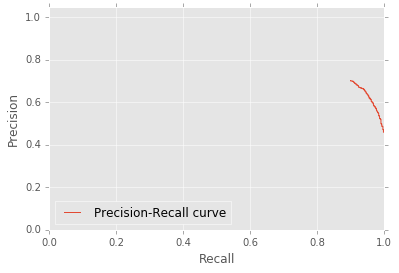

In [37]:
re90_mask = recall >= 0.9
pr_target_idx = np.arange(len(precision))[re90_mask]
pr_target = precision[re90_mask]

max_pr_idx = pr_target_idx[np.argmax(pr_target)]

print "Какую максимальную точность при этом можно получить?"
print precision[max_pr_idx]
print "При каком пороге?"
threshold90 = pr_thresholds[max_pr_idx]
print threshold90

plot_precision_recall_curve(recall[re90_mask], precision[re90_mask])

Возьмите классификатор с порогом из предыдущего пункта и подсчитайте для него F-меру. Почему она получилась маленькой, несмотря на высокую полноту?

In [38]:
# F-мера - среднее гармоническое precision и recall (2*recall*precision/recall+precision)
# она растет тогда, когда precision и recall растут одновременно,
# в нашем случае значение точности 0.701948051948, что и повлияло на значение fscore

In [41]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred>=threshold90)

0.78876322510032837

Допустим, что университету важно подавать как можно меньше заявок, которые окажутся неуспешными — они очень плохо влияют на репутацию. Установим нижнюю границу на точность 80%. Какую максимальную полноту при этом можно обеспечить? При каком пороге?

Какую максимальную полноту при этом можно обеспечить?
0.776019983347
При каком пороге?
0.528989973444


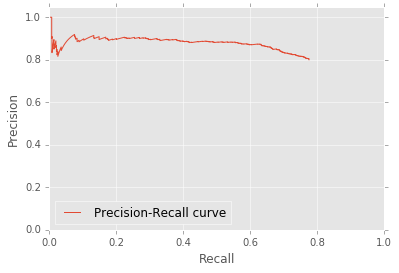

In [42]:
pr80_mask = precision >= 0.8
re_target_idx = np.arange(len(recall))[pr80_mask]
re_target = recall[pr80_mask]

max_re_idx = re_target_idx[np.argmax(re_target)]

print "Какую максимальную полноту при этом можно обеспечить?"
print recall[max_re_idx]
print "При каком пороге?"
print pr_thresholds[max_re_idx]

plot_precision_recall_curve(recall[pr80_mask], precision[pr80_mask])

#### Задание 5
В этом задании мы научимся оценивать способность классификатора предсказывать вероятности, а также разберемся с калибровкой.

Начнем с калибровочных кривых. Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [43]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 20
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((r - l) / 2.0  + l)
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds <= r)] == 1))
    ax = plt.plot(bin_middle_points, bin_real_ratios)
    plt.axis([-0.05, 1.05, -0.05, 1.05])

Проверим её работу на логистической регрессии (поменяйте имена переменных, если это необходимо). Получилась ли почти диагональная калибровочная кривая? **Почти.**

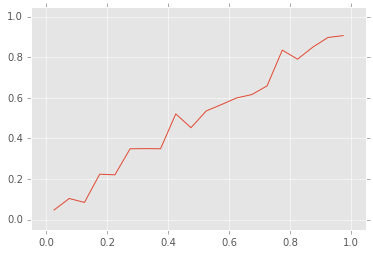

In [44]:
target_clf = LogisticRegression(C=1.0)
target_clf.fit(X, y_train)
preds = target_clf.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

Заодно обратим внимание на то, как часто классификатор выдает те или иные вероятности.

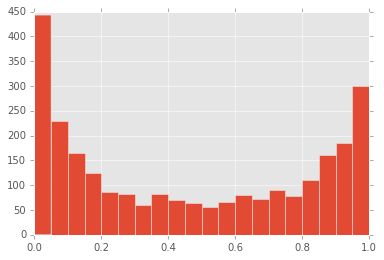

In [45]:
plt.hist(preds, bins=20)
plt.show()

Обучим теперь классификатор с кусочно-линейной функцией потерь (hinge loss, как в SVM).

In [46]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge')
clf.fit(X, y_train)
preds = clf.decision_function(X_test)
preds = 1.0 / (1.0 + np.exp(-preds))

Изучите распределение ответов классификатора.
Чем оно отличается от распределения у логистической регрессии?
**тем, что ответы у SGDClassifier распределены только в граничных точках**

Чем вы можете объяснить это?
**тем, что оптимизируемый функционал hinge loss не обладает свойствами вероятностной, его основное свойство - максимизация отступа от разделяющей поверхности. Модель возвращает отступы, абсолютные значения которых велики. Из-за асимтотических свойств сигмоидальной функции на отступах она будет принимать значения сконцентрированные у 0 и 1**

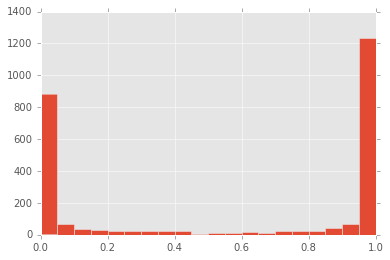

In [47]:
plt.hist(preds, bins=20)
plt.show()

Нарисуем калибровочную кривую. Видите ли вы какие-либо проблемы в ней? **да, у нее много резких скачков**

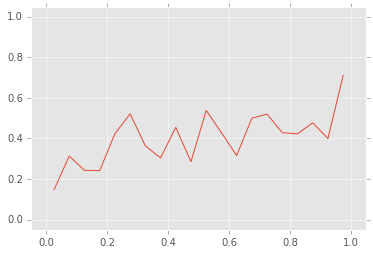

In [48]:
plot_calibration_curve(y_test, preds)

Попробуем откалибровать вероятности. Грубо говоря, это процедура, которая для каждого отрезка $[a_i, b_i]$ строит преобразование, которое корректирует вероятности в нем, приводя тем самым калибровочную кривую к диагональной форме.

Воспользуйтесь классом sklearn.calibration.CalibratedClassifierCV для калибровки вероятностей на обучении, и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она? **да, намного**

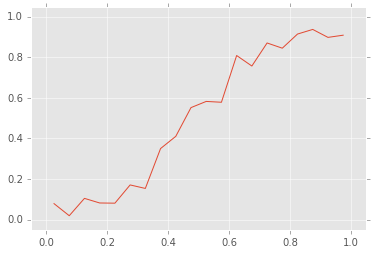

In [49]:
from sklearn.calibration import CalibratedClassifierCV
ccc = CalibratedClassifierCV(clf)
ccc.fit(X, y_train)
preds = ccc.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, preds)

#### Задание 6
Здесь вы можете вставить вашу любимую картинку про Австралию.

![](http://i.dailymail.co.uk/i/pix/2014/04/15/article-0-1D1ED54A00000578-626_634x413.jpg)

## Часть 2. Градиентный спуск своими руками
**(опциональная часть, за правильное выполнение к оценке добавляется 3 балла)**

В этой части вам предстоит самостоятельно реализовать градиентный спуск для логистической функции потерь — то есть, по сути, собственными руками обучить логистическую регрессию. Будем использовать данные из предыдущей части.

Добавьте к обучающей и тестовой выборкам единичный признак. Переведите значения целевого вектора в множество $\{-1, +1\}$.

In [50]:
X = np.hstack((np.ones((X.shape[0], 1), dtype=X.dtype), X))
X_test = np.hstack((np.ones((X_test.shape[0], 1), dtype=X_test.dtype), X_test))
y_train[y_train == 0] = -1
y_test[y_test == 0] = -1

In [51]:
X_test.shape, X.shape

((2613, 11735), (6095, 11735))

Для начала реализуйте функции, которые вычисляют функционал, его градиент, а также прогнозы модели.

In [52]:
def sigmoid(z):  
    return 1 / (1 + np.exp(-z))

In [53]:
# возвращает вектор предсказанных вероятностей для выборки X
def make_pred(X, w):
    return sigmoid(np.dot(X, w))

In [54]:
# возвращает значение логистического функционала для выборки (X, y) и вектора весов w
def get_func(w, X, y):    
    return np.sum(np.log(1 + np.exp(-y*np.dot(X, w))))

In [55]:
# возвращает градиент логистического функционала для выборки (X, y) и вектора весов w
def get_grad(w, X, y):
    return np.dot(X.T, y*(sigmoid(y*np.dot(X, w)) - 1))/X.shape[0]

Теперь реализуйте градиентный спуск (не стохастический). Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В градиентном спуске должно выполняться не более max_iter итераций.

In [60]:
import sys

In [72]:
def grad_descent(X, y, step_size, max_iter):
    w = np.zeros(X.shape[1])
    
    scores = []
    for i in range(max_iter):                
        score = get_func(w, X, y)
        grad = get_grad(w, X, y)
        w -= step_size * grad
        
        sys.stdout.write("\r Step size = %f, Iter = %i, Score = %f" % (step_size, i, score))
        sys.stdout.flush()
    
        scores.append(score)
    return w, scores

In [170]:
def plot_result(result, step_size, auc=None):
    coef, scores = result
    if auc is None:
        auc = roc_auc_score(y_test, make_pred(x_test, coef))
    plt.figure(figsize=(12, 7))
    plt.title("Step size %0.2f (Auc=%0.2f)" % (step_size, auc))
    plt.plot(range(len(scores)), scores)
    plt.xlabel('Iteration')
    plt.ylabel('Log Loss')

Запустите градиентный спуск для значений размера шага из набора [0.001, 1, 10]. Нарисуйте кривые зависимости значения функционала от номера итерации. Проанализируйте их. Вычислите AUC-ROC на тестовой выборке для лучшего из обученных вариантов.

In [91]:
step_size_grid = [0.001, 1, 10]

In [92]:
gd_results = [grad_descent(X, y_train, step_size, 400) for step_size in step_size_grid]

 Step size = 10.000000, Iter = 399, Score = 12989.888434

**При размере шага в 0.001 функционал медленно, но верно минимизируется.**

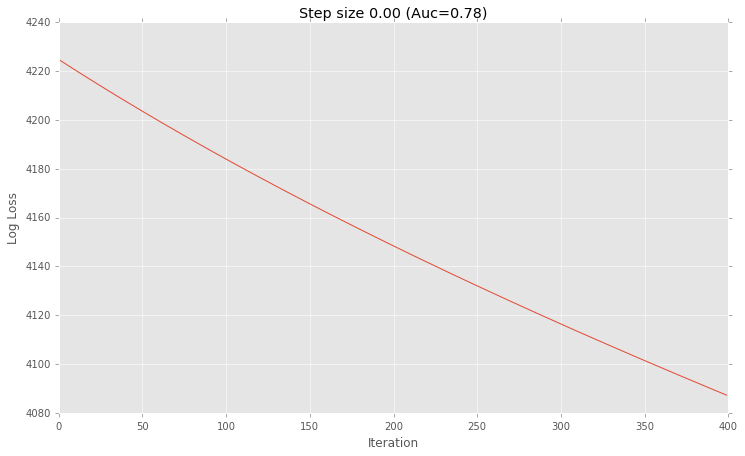

In [158]:
plot_result(gd_results[0], step_size_grid[0])

**При размере шага в 1.0 сходится намного быстрей, чем в предыдущем случае.**

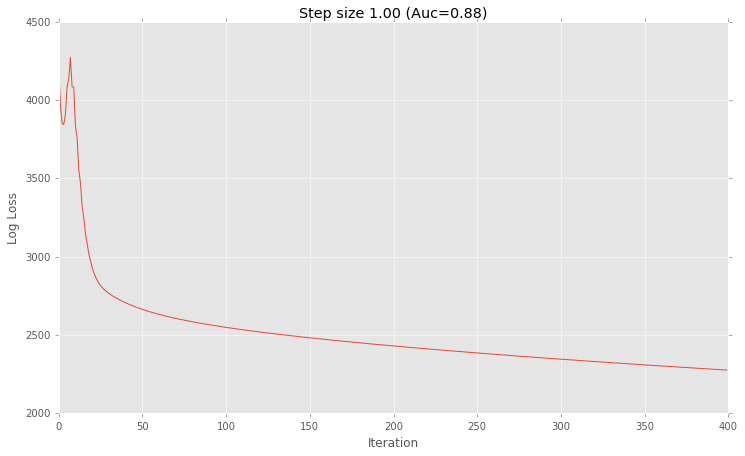

In [159]:
plot_result(gd_results[1], step_size_grid[1])

**При размере шага в 10.0 после итерации 50 значение функционала начинает прыгать. Сходимость не наблюдается.**

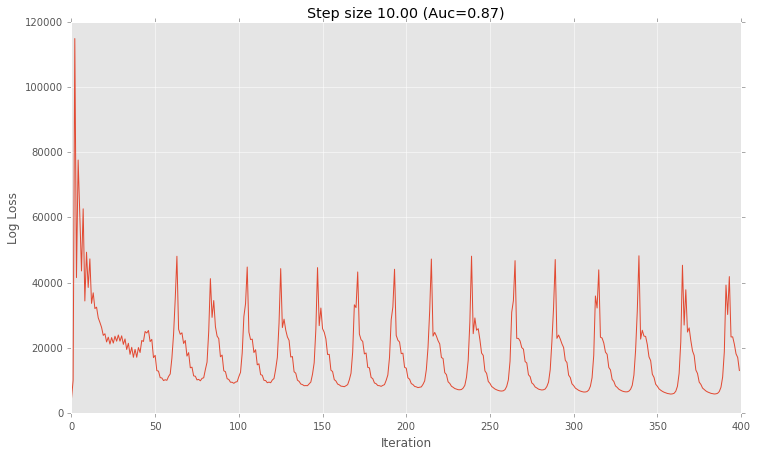

In [160]:
plot_result(gd_results[2], step_size_grid[2])

Теперь реализуйте стохастический градиентный спуск. Функция должна возвращать вектор весов и список значений функционала на каждой итерации. В стохастическом градиентном спуске должно выполняться не более max_iter итераций.

In [118]:
def sgd(X, y, step_size, max_iter):
    n_samples, n_features = X.shape

    w = np.zeros(n_features)
    
    scores = []
    for i in range(max_iter):
        st_idx = np.random.choice(X.shape[0], 1, replace=False)
        grad = get_grad(w, X[st_idx,:], y[st_idx])
        w -= step_size * grad
        score = get_func(w, X, y)
        scores.append(score)
        
        sys.stdout.write("\r Step size = %f, Iter = %i, Score = %f" % (step_size, i, score))
        sys.stdout.flush()

    return w, scores

Подберите размер шага, при котором SGD будет сходиться. Нарисуйте график сходимости. Вычислите AUC-ROC на тестовой выборке(В title-е графика).

In [119]:
sgd_coef, sgd_scores = sgd(X, y_train, 0.01, 1000)

 Step size = 0.010000, Iter = 999, Score = 3159.253551

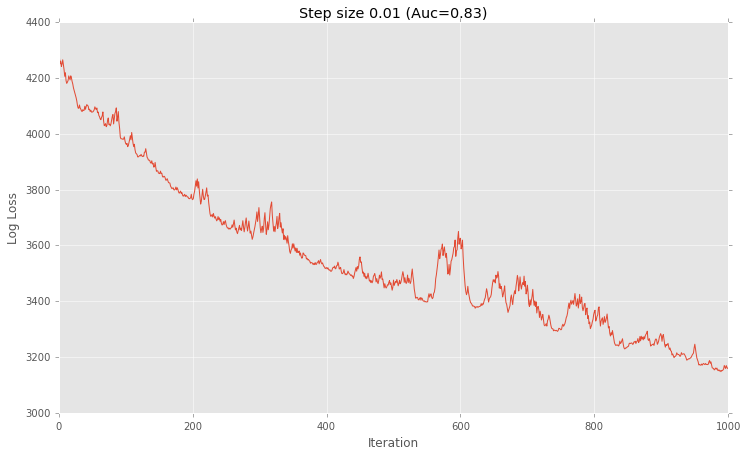

In [121]:
plot_result((sgd_coef, sgd_scores), 0.01)

А теперь самое сложное: заново сформируйте выборку с помощью transform_data, но теперь не масштабируйте вещественные признаки. Запустите на этой выборке градиентный спуск. Что вы наблюдаете? Удается ли достичь такого же качества, как и при использовании масштабирования?

**Эмпирическим путем установленно, что если задать шаг в 0.000002, то функционал можно оптимизировать, но это займет вечность.  Для больших значений шага, градиентный спуск начинает прыгать и сходимости нет. Качество сильно упало.**

In [123]:
def transform_data2(data, transformer, is_test):
    cols = data.columns
    numeric_cols = ['RFCD.Percentage.1', 'RFCD.Percentage.2', 'RFCD.Percentage.3', 
                    'RFCD.Percentage.4', 'RFCD.Percentage.5',
                    'SEO.Percentage.1', 'SEO.Percentage.2', 'SEO.Percentage.3',
                    'SEO.Percentage.4', 'SEO.Percentage.5',
                    'Year.of.Birth.1', 'Number.of.Successful.Grant.1', 'Number.of.Unsuccessful.Grant.1']
    categorical_cols = list(set(cols) - set(numeric_cols))

    numeric_data = data[numeric_cols].fillna(0)
    categorical_data = data[categorical_cols].fillna('nan').astype(str)
    
    if is_test:
        categorical_data = transformer.transform(categorical_data.T.to_dict().values())
    else:
        categorical_data = transformer.fit_transform(categorical_data.T.to_dict().values())

    return np.hstack((numeric_data,categorical_data)), transformer

In [167]:
transformer = DictVectorizer(sparse=False)
x_train2, transformer = transform_data2(data_train, transformer, False)
x_test2, _ = transform_data2(data_test, transformer, True)
x_train2 = np.hstack((np.ones((x_train2.shape[0], 1), dtype=x_train2.dtype), x_train2))
x_test2 = np.hstack((np.ones((x_test2.shape[0], 1), dtype=x_test2.dtype), x_test2))


In [168]:
gr2_coef, gr2_scores = grad_descent(x_train2, y_train, 0.0001, 150)

 Step size = 0.000100, Iter = 149, Score = 12442.047680

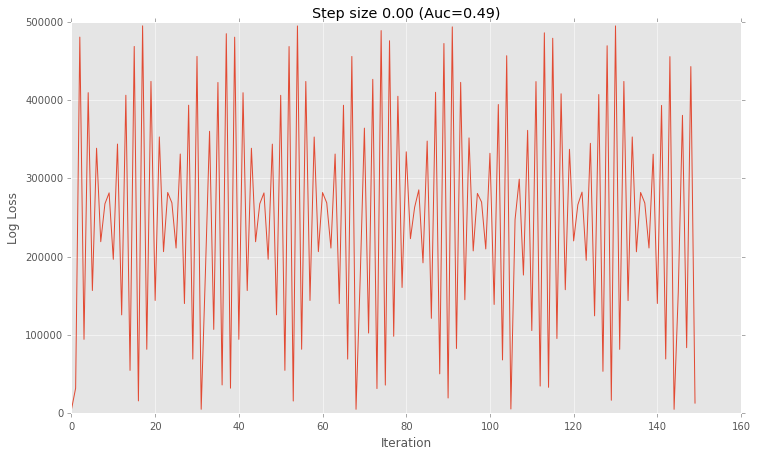

In [171]:
plot_result((gr2_coef, gr2_scores), 0.0001, roc_auc_score(y_test, make_pred(x_test2, gr2_coef)))

In [172]:
gr2_coef, gr2_scores = grad_descent(x_train2, y_train, 0.000002, 150)

 Step size = 0.000002, Iter = 149, Score = 4208.529818

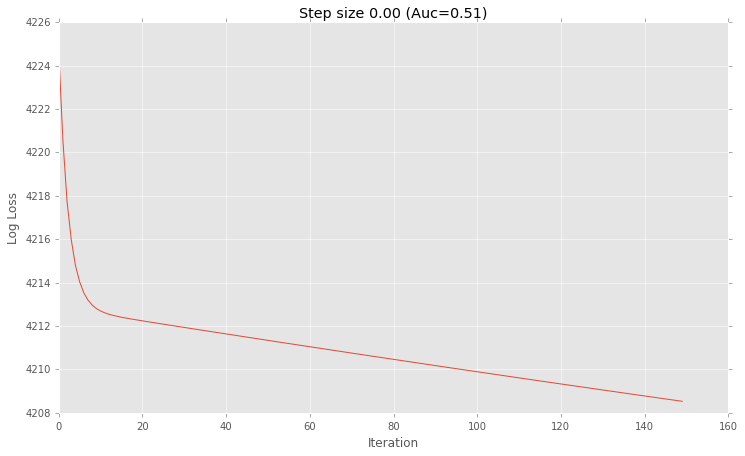

In [173]:
plot_result((gr2_coef, gr2_scores), 0.000002, roc_auc_score(y_test, make_pred(x_test2, gr2_coef)))

Здесь вы можете поделиться своими мыслями по поводу этой части.

![](http://301-1.ru/gen-mems/img_mems/8cc937c1ca991ce370aab522fb6af090.jpg)

## Часть 3. Линейная регрессия на простом примере

В этой части мы очень кратко разберемся с линейной регрессией и измерением качества ее прогнозов. Будем использовать датасет diabetes.

In [176]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
data = datasets.load_diabetes()
X, X_test, y, y_test = train_test_split(data.data, data.target, train_size=0.7, random_state=241)

In [180]:
X.shape

(309, 10)

Обучите линейную регрессию с L2-регуляризатором, подобрав лучшее значение параметра регуляризации на тестовой выборке. Используйте MSE в качестве функционала качества. При каком значении этого параметра достигается наилучшее качество?

** 0.001**

In [177]:
alpha_grid = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

Вычислите для лучшей из моделей RMSE(**55.85**) и коэффициент детерминации (r2_score(**0.41**)) на тестовой выборке. Что вы можете сказать о значении коэффицинта детерминации? Насколько данная модель близка к оптимальной?

**Коэффициент детерминации является квадратом множественного коэффициента корреляции между зависимой переменной и объясняющими переменными. Или как доля дисперсии зависимой переменной, объясняемая объясняющими переменными.**

In [178]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [182]:
ridge, ridge_params = search_params(Ridge(),{'alpha': alpha_grid,}, X, y, "mean_squared_error", cv=3)

Best parameters set found on development set:
()
{'alpha': 0.1}
()
Grid scores on development set:
()
-3079.860 (+/-966.372) for {'alpha': 0.001}
-3063.506 (+/-971.200) for {'alpha': 0.01}
-3059.737 (+/-928.683) for {'alpha': 0.1}
-3720.012 (+/-817.313) for {'alpha': 1.0}
-5481.688 (+/-800.862) for {'alpha': 10.0}
-6132.216 (+/-809.555) for {'alpha': 100.0}
()


In [183]:
y_pred = ridge.predict(X_test)

In [184]:
rmse = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))

In [186]:
print rmse(y_test, y_pred)

55.6419819113


In [187]:
from sklearn.metrics import r2_score

In [188]:
r2_score(y_test, y_pred)

0.41702418482173675